In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from PIL import Image
import io
import pymssql
from sklearn.preprocessing import StandardScaler
import os
import pickle
from azure.storage.blob import BlobServiceClient
import warnings

try:
    plt.style.use('seaborn-v0_8')
except:
    plt.style.use('seaborn')
sns.set_palette("husl")



In [ ]:
# Database Configuration
SERVER = "server"
DATABASE = "db"
USERNAME = "username"
PASSWORD = "password"

STORAGE_ACCOUNT_NAME = "account"  
STORAGE_ACCOUNT_KEY = "key+ASt7cDLtQ=="  

CONTAINER_NAME_IMAGES = "container"  
CONTAINER_NAME_DATA = "container" 

PARQUET_BLOB_PATH = "city_wellness_curated.parquet"  
MEDICAL_IMAGES_PREFIX = "medical_images/"  

MODEL_DIR = 'Database/models'

def get_connection():
    return pymssql.connect(
        server=SERVER,
        user=USERNAME,
        password=PASSWORD,
        database=DATABASE,
        port=1433,
        tds_version="7.4"
    )

def get_blob_service_client():
    try:
        connection_string = f"DefaultEndpointsProtocol=https;AccountName={STORAGE_ACCOUNT_NAME};AccountKey={STORAGE_ACCOUNT_KEY};EndpointSuffix=core.windows.net"
        blob_service_client = BlobServiceClient.from_connection_string(connection_string)
        return blob_service_client
    except Exception as e:
        print(f"Warning: Could not initialize blob service client: {e}")
        print("Make sure to update STORAGE_ACCOUNT_NAME and STORAGE_ACCOUNT_KEY")
        return None

blob_service_client = get_blob_service_client()


## Database Helper Functions


In [ ]:
def compare_quote_scenarios(customer_id, scenarios, from_blob=True):
    results = []
    
    for scenario in scenarios:
        scenario_name = scenario.get('name', 'Scenario')
        city = scenario.get('city', None)
        base_premium = scenario.get('base_premium', 200)
        ct_image_blob = scenario.get('ct_image_blob', None)
        ct_risk_override = scenario.get('ct_risk_score', None)
        
        try:
            if ct_risk_override is not None:
                scores = ensure_scores(
                    customer_id=customer_id,
                    city=city,
                    ct_image_blob=ct_image_blob,
                    from_blob=from_blob
                )
                scores['CT_RiskScore'] = ct_risk_override
            else:
                scores = ensure_scores(
                    customer_id=customer_id,
                    city=city,
                    ct_image_blob=ct_image_blob,
                    from_blob=from_blob
                )
            
            premium = compute_premium(
                base_premium,
                scores['CT_RiskScore'],
                scores['WellnessScore']
            )
            
            ct_adjustment = base_premium * 0.4 * scores['CT_RiskScore']
            wellness_adjustment = base_premium * 0.6 * (1 - scores['WellnessScore'])
            total_adjustment = ct_adjustment + wellness_adjustment
            adjustment_percent = (total_adjustment / base_premium) * 100
            
            results.append({
                'Scenario': scenario_name,
                'City': city or 'Auto',
                'Base Premium': base_premium,
                'CT Risk Score': scores['CT_RiskScore'],
                'Wellness Score': scores['WellnessScore'],
                'CT Adjustment': ct_adjustment,
                'Wellness Adjustment': wellness_adjustment,
                'Total Adjustment': total_adjustment,
                'Adjustment %': adjustment_percent,
                'Final Premium': premium,
                'Premium Difference': None,  
                'Status': 'Success'
            })
            
        except Exception as e:
            results.append({
                'Scenario': scenario_name,
                'City': city or 'Auto',
                'Base Premium': base_premium,
                'CT Risk Score': None,
                'Wellness Score': None,
                'CT Adjustment': None,
                'Wellness Adjustment': None,
                'Total Adjustment': None,
                'Adjustment %': None,
                'Final Premium': None,
                'Premium Difference': None,
                'Status': f'Error: {str(e)[:50]}'
            })
    
    df = pd.DataFrame(results)
    
    if len(df) > 0 and df.iloc[0]['Final Premium'] is not None:
        baseline_premium = df.iloc[0]['Final Premium']
        df['Premium Difference'] = df['Final Premium'] - baseline_premium
        df['Premium Difference %'] = (df['Premium Difference'] / baseline_premium) * 100
    
    return df



In [6]:
def get_customer(customer_id):
    conn = get_connection()
    cursor = conn.cursor(as_dict=True)
    cursor.execute("SELECT * FROM Customer WHERE CustomerID = %s", (customer_id,))
    row = cursor.fetchone()
    conn.close()
    return row

def get_health_factors(customer_id):
    conn = get_connection()
    cursor = conn.cursor(as_dict=True)
    cursor.execute("""
        SELECT FactorName, FactorValue
        FROM CustomerHealthFactor
        WHERE CustomerID = %s
    """, (customer_id,))
    rows = cursor.fetchall()
    conn.close()
    return rows

def insert_health_factor(customer_id, factor_name, factor_value, year=2024, asset_id=1):
    conn = get_connection()
    cursor = conn.cursor()
    cursor.execute("""
        INSERT INTO CustomerHealthFactor (CustomerID, FactorName, FactorValue, FactorYear, SourceAssetID)
        VALUES (%s, %s, %s, %s, %s)
    """, (customer_id, factor_name, factor_value, year, asset_id))
    conn.commit()
    conn.close()

def get_customer_image_blob(customer_id):
    conn = get_connection()
    cursor = conn.cursor(as_dict=True)
    cursor.execute("""
        SELECT TOP 1 ImageFileName 
        FROM CustomerHealthFactor 
        WHERE CustomerID = %s AND ImageFileName IS NOT NULL
        ORDER BY FactorID DESC
    """, (customer_id,))
    row = cursor.fetchone()
    conn.close()
    return row["ImageFileName"] if row and "ImageFileName" in row else None



## Load ML Models


In [ ]:
ct_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def load_ct_model(model_path):
    model = models.resnet18(weights="IMAGENET1K_V1")
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 1),
        nn.Sigmoid()
    )
    
    if model_path and os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Loaded CT model from {model_path}")
    else:
        print("Warning: Using ImageNet-initialized CT model. Train and save model first.")
    
    model = model.to(device)
    model.eval()
    return model

class WellnessNN(nn.Module):
    def __init__(self, input_size=9):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.net(x)

def load_wellness_model(model_path, scaler_path, input_size=9):
    model = WellnessNN(input_size=input_size)
    
    if model_path and os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Loaded wellness model from {model_path}")
    else:
        print("Warning: Using untrained wellness model. Train and save model first.")
    
    model = model.to(device)
    model.eval()
    
    scaler = None
    if scaler_path and os.path.exists(scaler_path):
        with open(scaler_path, 'rb') as f:
            scaler = pickle.load(f)
        print(f"Loaded scaler from {scaler_path}")
    else:
        print("Warning: No scaler found. Using StandardScaler (will need fitting).")
        scaler = StandardScaler()
    
    return model, scaler

ct_model = load_ct_model(os.path.join(MODEL_DIR, 'ct_risk_model.pth'))
wellness_model, wellness_scaler = load_wellness_model(
    model_path=os.path.join(MODEL_DIR, 'wellness_model.pth'),
    scaler_path=os.path.join(MODEL_DIR, 'wellness_scaler.pkl')
)


Loaded CT model from /Users/grishmadeshmukh/Desktop/NYUMasters/Sem3/Database/part4/models/ct_risk_model.pth
Loaded wellness model from /Users/grishmadeshmukh/Desktop/NYUMasters/Sem3/Database/part4/models/wellness_model.pth
Loaded scaler from /Users/grishmadeshmukh/Desktop/NYUMasters/Sem3/Database/part4/models/wellness_scaler.pkl


## Azure Blob Storage Functions


In [ ]:
_city_wellness_cache = None

def load_image_from_blob(blob_name, container_name=CONTAINER_NAME_IMAGES):
    if blob_service_client is None:
        raise ValueError("Azure Blob Storage client not initialized. Check configuration.")
    
    if not blob_name.startswith("medical_images/"):
        blob_name = MEDICAL_IMAGES_PREFIX + blob_name
    
    try:
        blob_client = blob_service_client.get_blob_client(container=container_name, blob=blob_name)
        blob_data = blob_client.download_blob().readall()
        img = Image.open(io.BytesIO(blob_data)).convert("RGB")
        return img
    except Exception as e:
        raise FileNotFoundError(f"Could not load image '{blob_name}' from blob storage: {e}")

def load_city_wellness_from_parquet(parquet_blob_path=None, container_name=CONTAINER_NAME_DATA):
    global _city_wellness_cache
    
    if _city_wellness_cache is not None:
        return _city_wellness_cache
    
    if blob_service_client is None:
        raise ValueError("Azure Blob Storage client not initialized. Check configuration.")
    
    if parquet_blob_path is None:
        parquet_blob_path = PARQUET_BLOB_PATH
    
    try:
        blob_client = blob_service_client.get_blob_client(container=container_name, blob=parquet_blob_path)
        blob_data = blob_client.download_blob().readall()
        
        try:
            df = pd.read_parquet(io.BytesIO(blob_data), engine='pyarrow')
        except (ValueError, ImportError, AttributeError) as e:
            if 'pandas.period' in str(e) or 'already defined' in str(e):
                print("  pyarrow conflict detected, trying fastparquet...")
                try:
                    df = pd.read_parquet(io.BytesIO(blob_data), engine='fastparquet')
                except ImportError:
                    raise ImportError("fastparquet not installed. Please run: !pip install fastparquet")
            else:
                try:
                    df = pd.read_parquet(io.BytesIO(blob_data), engine='fastparquet')
                except ImportError:
                    raise ImportError("Neither pyarrow nor fastparquet working. Please reinstall: !pip uninstall -y pyarrow && !pip install pyarrow")
        
        if "Obesity levels(Country)" in df.columns:
            df["Obesity levels(Country)"] = df["Obesity levels(Country)"].astype(str).str.replace("%", "", regex=False)
        if "Cost of a bottle of water(City)" in df.columns:
            df["Cost of a bottle of water(City)"] = df["Cost of a bottle of water(City)"].astype(str).str.replace("£", "").str.replace("$", "").str.replace("€", "")
        if "Cost of a monthly gym membership(City)" in df.columns:
            df["Cost of a monthly gym membership(City)"] = df["Cost of a monthly gym membership(City)"].astype(str).str.replace("£", "").str.replace("$", "").str.replace("€", "")
        
        numeric_cols = [
            "Sunshine hours(City)",
            "Obesity levels(Country)",
            "Life expectancy(years) (Country)",
            "Pollution(Index score) (City)",
            "Annual avg. hours worked",
            "Happiness levels(Country)",
            "Outdoor activities(City)",
            "Cost of a bottle of water(City)",
            "Cost of a monthly gym membership(City)"
        ]
        
        for col in numeric_cols:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
        
        for col in numeric_cols:
            if col in df.columns:
                df[col] = df[col].fillna(df[col].mean())
        
        _city_wellness_cache = df
        print(f"✓ Loaded city wellness data from blob: {parquet_blob_path}")
        return df
        
    except Exception as e:
        raise FileNotFoundError(f"Could not load city wellness parquet '{parquet_blob_path}' from blob storage: {e}")

def load_city_features(city, parquet_blob_path=None):
    """Load city wellness features from Azure Blob Storage (parquet)."""
    df = load_city_wellness_from_parquet(parquet_blob_path)
    
    city_row = df[df['City'].str.lower() == city.lower()]
    if city_row.empty:
        raise ValueError(f"City '{city}' not found in city wellness data")
    
    numeric_cols = [
        "Sunshine hours(City)",
        "Obesity levels(Country)",
        "Life expectancy(years) (Country)",
        "Pollution(Index score) (City)",
        "Annual avg. hours worked",
        "Happiness levels(Country)",
        "Outdoor activities(City)",
        "Cost of a bottle of water(City)",
        "Cost of a monthly gym membership(City)"
    ]
    
    features = []
    for col in numeric_cols:
        if col in city_row.columns:
            val = city_row[col].iloc[0]
            features.append(float(val) if pd.notna(val) else 0.0)
        else:
            raise ValueError(f"Column '{col}' not found in city wellness data")
    
    return np.array(features, dtype=float)



## ML Score Computation Functions


In [ ]:
def compute_ct_risk(image_source, from_blob=True):
    if from_blob:
        img = load_image_from_blob(image_source)
    else:
        if not os.path.exists(image_source):
            raise FileNotFoundError(f"Image not found: {image_source}")
        img = Image.open(image_source).convert("RGB")
    
    img_tensor = ct_transform(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        score = ct_model(img_tensor).item()
    
    return float(score)

def update_ct_risk_score(customer_id, image_source, from_blob=True):
    score = compute_ct_risk(image_source, from_blob=from_blob)
    insert_health_factor(customer_id, "CT_RiskScore", score)
    return score

def update_wellness_score(customer_id, city):
    features = load_city_features(city)
    
    if hasattr(wellness_scaler, 'mean_') and wellness_scaler.mean_ is not None:
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', category=UserWarning, message='.*feature names.*')
            features_scaled = wellness_scaler.transform(features.reshape(1, -1))
    else:
        print("Warning: Scaler not fitted. Using raw features.")
        features_scaled = features.reshape(1, -1)
    
    features_tensor = torch.tensor(features_scaled, dtype=torch.float32).to(device)

    with torch.no_grad():
        score = float(wellness_model(features_tensor).item())

    insert_health_factor(customer_id, "WellnessScore", score)
    return score

def ensure_scores(customer_id, city=None, ct_image_blob=None, from_blob=True):
    existing = get_health_factors(customer_id)
    scores = {"CT_RiskScore": None, "WellnessScore": None}

    for row in existing:
        if row["FactorName"] in scores:
            scores[row["FactorName"]] = row["FactorValue"]

    if city is None:
        customer = get_customer(customer_id)
        if customer and "City" in customer:
            city = customer["City"]
        else:
            raise ValueError(f"City not provided and not found in customer record for ID {customer_id}")

    if scores["CT_RiskScore"] is None:
        if ct_image_blob is None:
            ct_image_blob = get_customer_image_blob(customer_id)
            if ct_image_blob is None:
                raise ValueError(f"CT image blob not found for customer {customer_id}. Provide ct_image_blob parameter.")
        
        scores["CT_RiskScore"] = update_ct_risk_score(customer_id, ct_image_blob, from_blob=from_blob)

    if scores["WellnessScore"] is None:
        scores["WellnessScore"] = update_wellness_score(customer_id, city)

    return scores

def compute_premium(base, ct_score, wellness_score):
    α = 0.4  # CT risk weight
    β = 0.6  # Wellness weight
    premium = base * (1 + α * ct_score + β * (1 - wellness_score))
    return float(premium)



## Quote Comparison Functions


In [ ]:
def visualize_premium_comparison(comparison_df):
    if len(comparison_df) == 0:
        print("No data to visualize")
        return
    
    success_df = comparison_df[comparison_df['Status'] == 'Success'].copy()
    
    if len(success_df) == 0:
        print("No successful scenarios to visualize")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Premium Comparison Bar Chart
    ax1 = axes[0, 0]
    bars = ax1.bar(range(len(success_df)), success_df['Final Premium'], 
                    color=['steelblue', 'coral', 'lightgreen', 'gold', 'plum'][:len(success_df)])
    ax1.set_xticks(range(len(success_df)))
    ax1.set_xticklabels(success_df['Scenario'], rotation=45, ha='right')
    ax1.set_ylabel('Premium ($)', fontsize=12)
    ax1.set_title('Premium Comparison Across Scenarios', fontsize=14, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, (idx, row) in enumerate(success_df.iterrows()):
        ax1.text(i, row['Final Premium'] + 5, f"${row['Final Premium']:.2f}", 
                ha='center', va='bottom', fontsize=10)
    
    # 2. Premium Breakdown 
    ax2 = axes[0, 1]
    x_pos = range(len(success_df))
    base_values = success_df['Base Premium'].values
    ct_adjustments = success_df['CT Adjustment'].values
    wellness_adjustments = success_df['Wellness Adjustment'].values
    
    ax2.bar(x_pos, base_values, label='Base Premium', color='lightblue')
    ax2.bar(x_pos, ct_adjustments, bottom=base_values, label='CT Risk Adjustment', color='coral')
    ax2.bar(x_pos, wellness_adjustments, bottom=base_values + ct_adjustments, 
            label='Wellness Adjustment', color='lightgreen')
    
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(success_df['Scenario'], rotation=45, ha='right')
    ax2.set_ylabel('Premium ($)', fontsize=12)
    ax2.set_title('Premium Breakdown by Component', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    
    # 3. Risk Scores Comparison
    ax3 = axes[1, 0]
    x = range(len(success_df))
    width = 0.35
    ax3.bar([i - width/2 for i in x], success_df['CT Risk Score'], width, 
            label='CT Risk Score', color='coral', alpha=0.7)
    ax3.bar([i + width/2 for i in x], success_df['Wellness Score'], width, 
            label='Wellness Score', color='lightgreen', alpha=0.7)
    ax3.set_xticks(x)
    ax3.set_xticklabels(success_df['Scenario'], rotation=45, ha='right')
    ax3.set_ylabel('Score (0-1)', fontsize=12)
    ax3.set_title('Risk Scores Comparison', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)
    ax3.set_ylim(0, 1)
    
    # 4. Premium Difference from Baseline
    ax4 = axes[1, 1]
    if 'Premium Difference' in success_df.columns and success_df['Premium Difference'].notna().any():
        colors = ['green' if x < 0 else 'red' if x > 0 else 'gray' 
                 for x in success_df['Premium Difference']]
        bars = ax4.bar(range(len(success_df)), success_df['Premium Difference'], color=colors, alpha=0.7)
        ax4.axhline(y=0, color='black', linestyle='--', linewidth=1)
        ax4.set_xticks(range(len(success_df)))
        ax4.set_xticklabels(success_df['Scenario'], rotation=45, ha='right')
        ax4.set_ylabel('Premium Difference ($)', fontsize=12)
        ax4.set_title('Premium Difference from Baseline Scenario', fontsize=14, fontweight='bold')
        ax4.grid(axis='y', alpha=0.3)
        
        # Add value labels
        for i, (idx, row) in enumerate(success_df.iterrows()):
            if pd.notna(row['Premium Difference']):
                ax4.text(i, row['Premium Difference'] + (5 if row['Premium Difference'] > 0 else -10), 
                        f"${row['Premium Difference']:+.2f}", 
                        ha='center', va='bottom' if row['Premium Difference'] > 0 else 'top', fontsize=9)
    else:
        ax4.text(0.5, 0.5, 'No baseline comparison available', 
                ha='center', va='center', transform=ax4.transAxes, fontsize=12)
        ax4.set_title('Premium Difference from Baseline', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def display_comparison_table(comparison_df):
    if len(comparison_df) == 0:
        print("No comparison data available")
        return
    
    display_df = comparison_df.copy()
    currency_cols = ['Base Premium', 'CT Adjustment', 'Wellness Adjustment', 
                     'Total Adjustment', 'Final Premium', 'Premium Difference']
    for col in currency_cols:
        if col in display_df.columns:
            display_df[col] = display_df[col].apply(
                lambda x: f"${x:.2f}" if pd.notna(x) else "N/A"
            )
    pct_cols = ['Adjustment %', 'Premium Difference %']
    for col in pct_cols:
        if col in display_df.columns:
            display_df[col] = display_df[col].apply(
                lambda x: f"{x:.1f}%" if pd.notna(x) else "N/A"
            )
    
    score_cols = ['CT Risk Score', 'Wellness Score']
    for col in score_cols:
        if col in display_df.columns:
            display_df[col] = display_df[col].apply(
                lambda x: f"{x:.4f}" if pd.notna(x) else "N/A"
            )
    
    print("=" * 100)
    print(" " * 35 + "QUOTE COMPARISON RESULTS")
    print("=" * 100)
    print()
    display(display_df)
    print()
    print("=" * 100)


## Comparison 


                                   QUOTE COMPARISON TOOL

Comparing 5 scenarios for Customer ID: 1

                                   QUOTE COMPARISON RESULTS



,Scenario,City,Base Premium,CT Risk Score,Wellness Score,CT Adjustment,Wellness Adjustment,Total Adjustment,Adjustment %,Final Premium,Premium Difference,Status,Premium Difference %
0,Current (Auto),Auto,$200.00,0.7003,0.5549,$56.02,$53.41,$109.43,54.7%,$309.43,$0.00,Success,0.0%
1,Mumbai Option,Mumbai,$200.00,0.7003,0.5549,$56.02,$53.41,$109.43,54.7%,$309.43,$0.00,Success,0.0%
2,Amsterdam Option,Amsterdam,$200.00,0.7003,0.5549,$56.02,$53.41,$109.43,54.7%,$309.43,$0.00,Success,0.0%
3,Higher Base Premium,Auto,$300.00,0.7003,0.5549,$84.03,$80.11,$164.14,54.7%,$464.14,$154.71,Success,50.0%
4,Lower CT Risk (0.3),Auto,$200.00,0.3000,0.5549,$24.00,$53.41,$77.41,38.7%,$277.41,$-32.02,Success,-10.3%




                                   VISUALIZATIONS



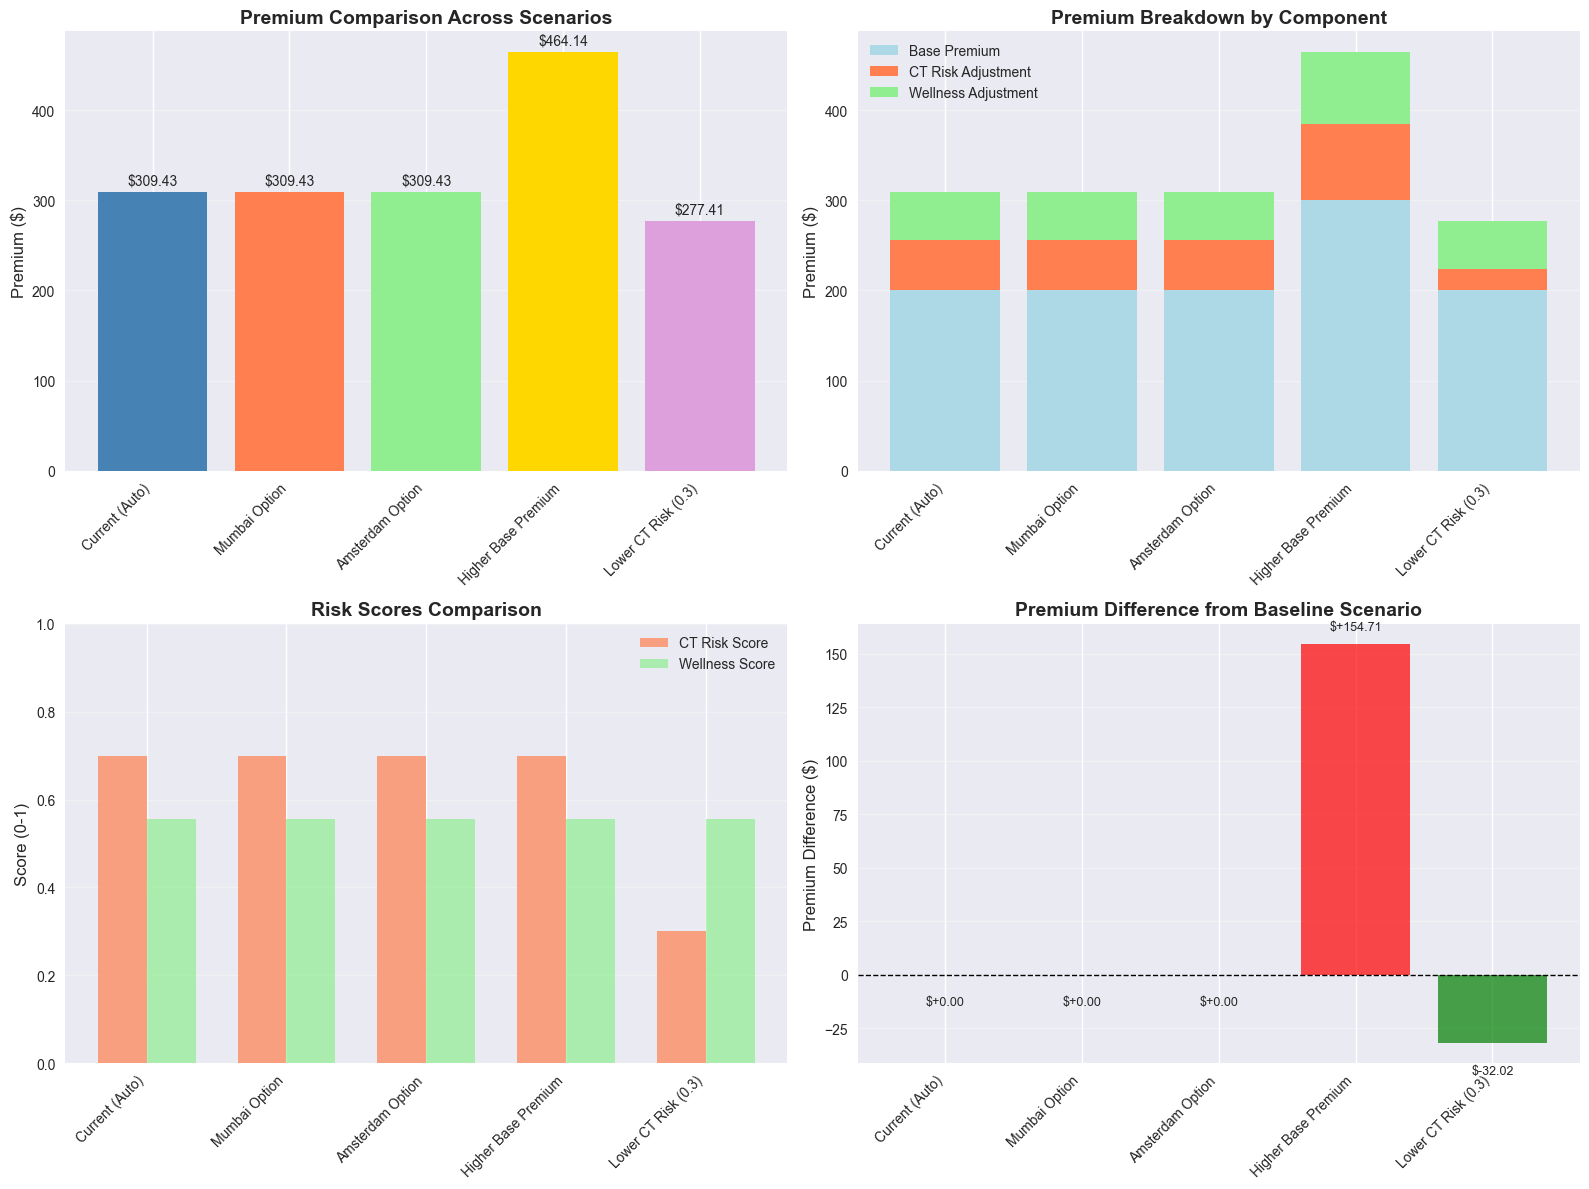


                                   SUMMARY

Baseline Scenario: Current (Auto)
  Premium: $309.43
  City: Auto
  CT Risk: 0.7003
  Wellness: 0.5549

Comparison Results:

  Mumbai Option:
    Premium: $309.43
    Difference: $+0.00 (+0.0%)
    City: Mumbai

  Amsterdam Option:
    Premium: $309.43
    Difference: $+0.00 (+0.0%)
    City: Amsterdam

  Higher Base Premium:
    Premium: $464.14
    Difference: $+154.71 (+50.0%)
    City: Auto

  Lower CT Risk (0.3):
    Premium: $277.41
    Difference: $-32.02 (-10.3%)
    City: Auto

  Best Option: Lower CT Risk (0.3) ($277.41)
  Most Expensive: Higher Base Premium ($464.14)
  Savings Potential: $186.74/month

                         ✓ Comparison Complete!


In [ ]:
# ============================================================================
# USER INPUT 
# ============================================================================

CUSTOMER_ID = 1  

# Define scenarios to compare
# Each scenario can have:
#   - 'name': Descriptive name
#   - 'city': City name (None = use customer's city)
#   - 'base_premium': Base premium amount
#   - 'ct_image_blob': CT image blob (None = use from database)
#   - 'ct_risk_score': Optional CT risk override (None = compute from image)

SCENARIOS = [
    {
        'name': 'Current (Auto)',
        'city': None,  # Use customer's city
        'base_premium': 200,
        'ct_image_blob': None,  # Use from database
        'ct_risk_score': None  # Compute from image
    },
    {
        'name': 'Mumbai Option',
        'city': 'Mumbai',  # Different city
        'base_premium': 200,
        'ct_image_blob': None,
        'ct_risk_score': None
    },
    {
        'name': 'Amsterdam Option',
        'city': 'Amsterdam',
        'base_premium': 200,
        'ct_image_blob': None,
        'ct_risk_score': None
    },
    {
        'name': 'Higher Base Premium',
        'city': None,
        'base_premium': 300,  
        'ct_image_blob': None,
        'ct_risk_score': None
    },
    {
        'name': 'Lower CT Risk (0.3)',
        'city': None,
        'base_premium': 200,
        'ct_image_blob': None,
        'ct_risk_score': 0.3  
    }
]


try:
    print("=" * 100)
    print(" " * 35 + "QUOTE COMPARISON TOOL")
    print("=" * 100)
    print()
    print(f"Comparing {len(SCENARIOS)} scenarios for Customer ID: {CUSTOMER_ID}")
    print()
    
    comparison_results = compare_quote_scenarios(
        customer_id=CUSTOMER_ID,
        scenarios=SCENARIOS,
        from_blob=True
    )
    
    display_comparison_table(comparison_results)
    
    print("\n" + "=" * 100)
    print(" " * 35 + "VISUALIZATIONS")
    print("=" * 100)
    print()
    visualize_premium_comparison(comparison_results)
    
    print("\n" + "=" * 100)
    print(" " * 35 + "SUMMARY")
    print("=" * 100)
    
    success_df = comparison_results[comparison_results['Status'] == 'Success']
    if len(success_df) > 0:
        baseline = success_df.iloc[0]
        print(f"\nBaseline Scenario: {baseline['Scenario']}")
        print(f"  Premium: ${baseline['Final Premium']:.2f}")
        print(f"  City: {baseline['City']}")
        print(f"  CT Risk: {baseline['CT Risk Score']:.4f}")
        print(f"  Wellness: {baseline['Wellness Score']:.4f}")
        
        print(f"\nComparison Results:")
        for idx, row in success_df.iterrows():
            if idx != success_df.index[0]:  
                diff = row['Premium Difference']
                diff_pct = (diff / baseline['Final Premium']) * 100 if baseline['Final Premium'] > 0 else 0
                print(f"\n  {row['Scenario']}:")
                print(f"    Premium: ${row['Final Premium']:.2f}")
                print(f"    Difference: ${diff:+.2f} ({diff_pct:+.1f}%)")
                print(f"    City: {row['City']}")
        
        if len(success_df) > 1:
            best = success_df.loc[success_df['Final Premium'].idxmin()]
            worst = success_df.loc[success_df['Final Premium'].idxmax()]
            print(f"\n  Best Option: {best['Scenario']} (${best['Final Premium']:.2f})")
            print(f"  Most Expensive: {worst['Scenario']} (${worst['Final Premium']:.2f})")
            print(f"  Savings Potential: ${worst['Final Premium'] - best['Final Premium']:.2f}/month")
    
    print("\n" + "=" * 100)
    print(" " * 25 + "✓ Comparison Complete!")
    print("=" * 100)
    
except Exception as e:
    print()
    print("=" * 100)
    print(" " * 40 + "ERROR")
    print("=" * 100)
    print(f"\n{str(e)}\n")
    import traceback
    traceback.print_exc()
